## Design considerations for extracting data from San Francisco civic issue tracking public API

Data would have to be pulled from https://data.sfgov.org/ so it makes sense to run a job periodically as a batch process (it doesn't seem likely that the data is updated close to real-time).

System should be able to load data incrementally if possible. It this case it is possible through provided API (https://dev.socrata.com/foundry/data.sfgov.org/ktji-gk7t). Initial data import would have to use the big file but then endpoint can be used with a date filter to get incremental update. Full import procedure should be repeatable and automated.

If the ETL process is complicated enough it's good to divide the whole process in components. Each component should follow basic UNIX philosophy: be composable, do one thing well, expect output of component to be input to another. If one component fails system should still be in a stable state without incomplete data, duplicates or data corruption.

Extending this pipeline to handle more data source would be an example of good use case for modular architecture. Extracting data could be done by different components or maybe the same one but running with different parameters. Same elements of data normalization and processing could be probably shared so this design approach would enable code reusing. 

If the data is very big in volume and/or if we want to use multiple workers to speed up the process, data should be partitioned. Files should be read in bulk for performance.

If multiple components are involved there should some kind of work flow system controlling their execution and allowing defining task dependencies and conditions. Such system should also handle failures in some way: maybe just reporting it, maybe retrying, running rollbacks etc. This could achieved through systems with more programmatic approach Airflow, Luigi, Spring Batch, full-on ETL system like Pentaho or Clover or custom one, implemented using Spark, Kafka or similar technology allowing distributing and controlling work between workers. Of course it's also possible to implement everything completely  by hand. 

Save, preferably non-local storage system should be used to store raw data from the the endpoint and data from intermediate steps. This is especially important if we want to use many distributed workers. That can self-hosted file system or Amazon S3, GCS or similar solution.

Then would be time for other parts E from ETL operations like:
* joining with other data set
* aggregation 
* adding calculated values
* transposing or pivoting
or similar


b'Skipping line 342: expected 19 fields, saw 20\nSkipping line 1056: expected 19 fields, saw 20\nSkipping line 1298: expected 19 fields, saw 20\nSkipping line 2210: expected 19 fields, saw 21\nSkipping line 5346: expected 19 fields, saw 20\nSkipping line 8235: expected 19 fields, saw 20\nSkipping line 10507: expected 19 fields, saw 20\nSkipping line 11047: expected 19 fields, saw 20\nSkipping line 11802: expected 19 fields, saw 21\nSkipping line 12460: expected 19 fields, saw 20\nSkipping line 13394: expected 19 fields, saw 20\nSkipping line 20254: expected 19 fields, saw 20\nSkipping line 21485: expected 19 fields, saw 22\nSkipping line 21656: expected 19 fields, saw 20\nSkipping line 22347: expected 19 fields, saw 20\nSkipping line 30379: expected 19 fields, saw 20\nSkipping line 30634: expected 19 fields, saw 20\nSkipping line 30687: expected 19 fields, saw 20\nSkipping line 31388: expected 19 fields, saw 20\nSkipping line 32527: expected 19 fields, saw 22\n'
b'Skipping line 34100: 

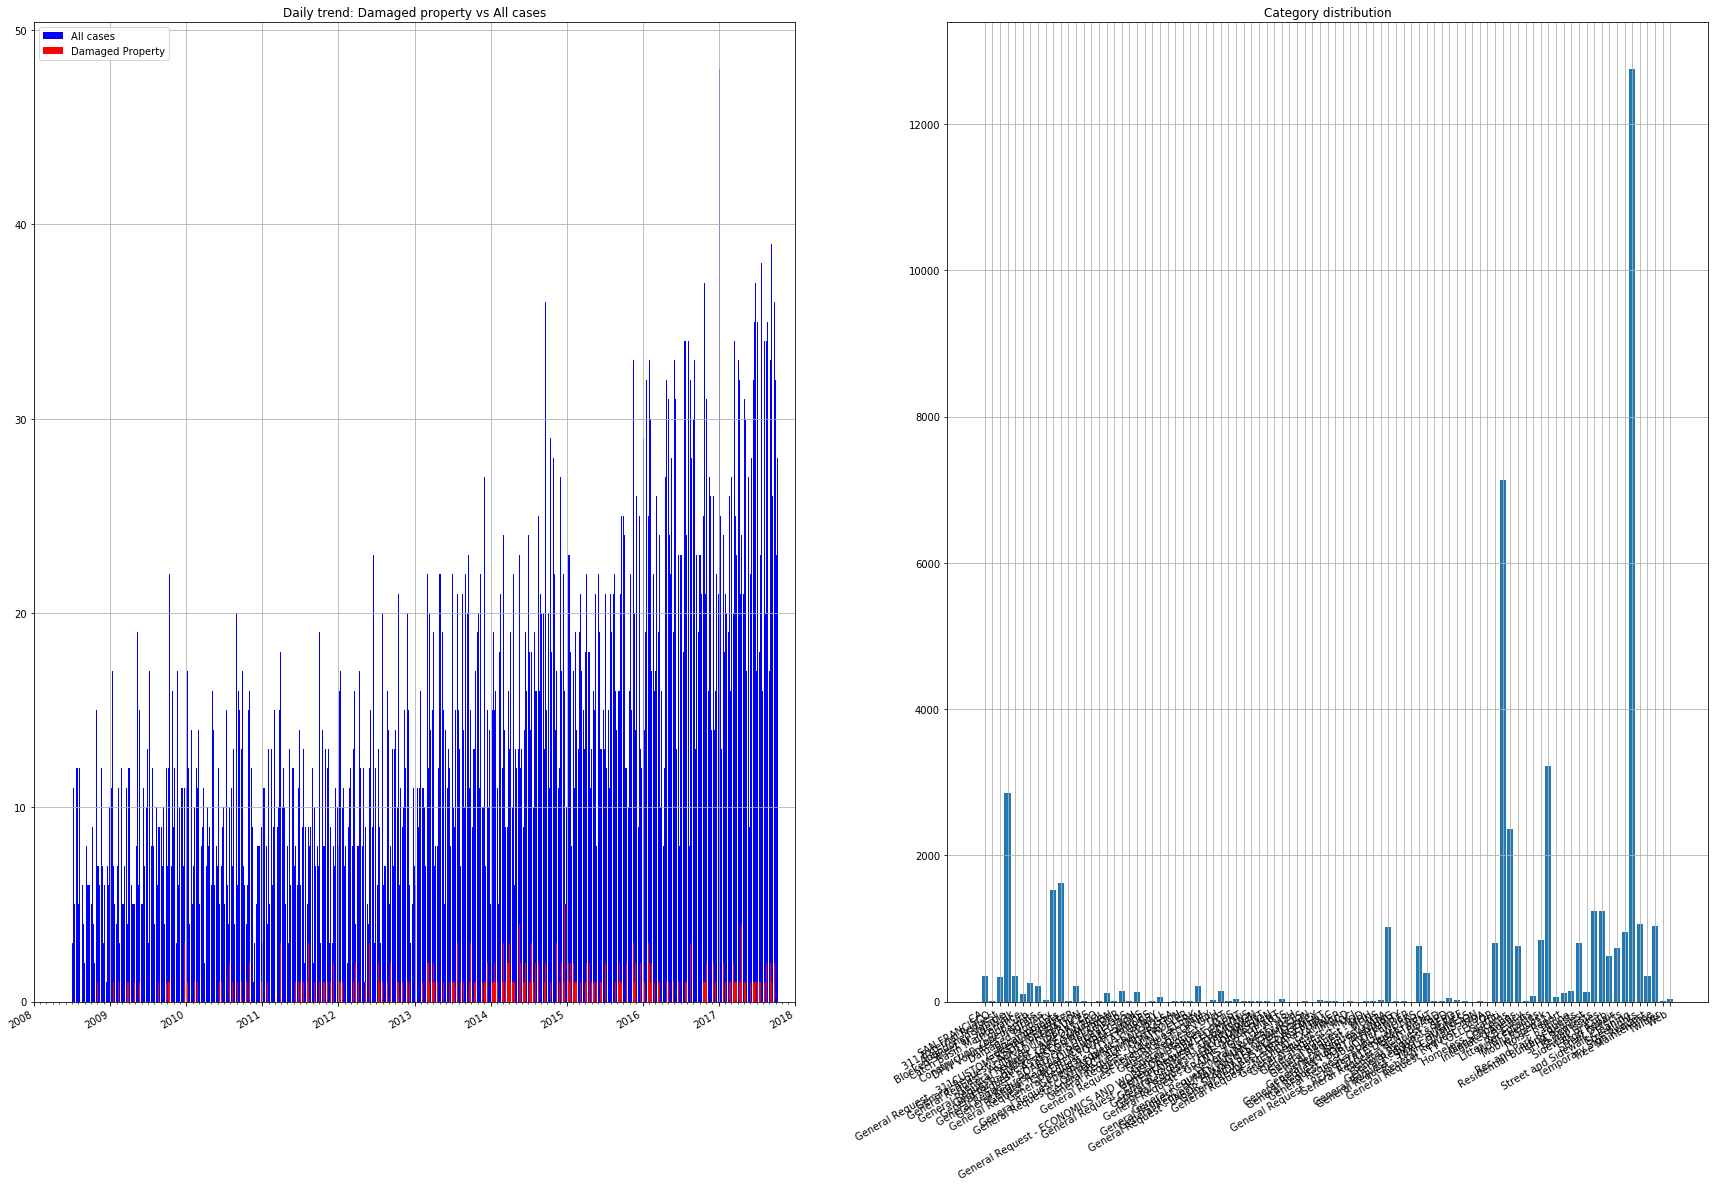

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

% matplotlib inline


dateparse = lambda dates: pd.to_datetime(dates, format='%m/%d/%Y %I:%M:%S %p', errors='coerce').date

df = pd.read_csv('sample_50k.csv', 
                 parse_dates=['Opened'], 
                 date_parser=dateparse,
                 error_bad_lines=False,
                 dtype={
                     'CaseID': str,
                     'Opened': str,
                     'Closed': str,
                     'Updated': str,
                     'Status': str,
                     'Status Notes': str,
                     'Responsible Agency': str,
                     'Category': str,
                     'Request Type': str,
                     'Request Details': str,
                     'Address': str,
                     'Supervisor District': str,
                     'Neighborhood': str,
                     'Police District': str,
                     'Latitude': str,
                     'Longitude': str,
                     'Point': str,
                     'Source': str,
                     'Media URL': str,
                 })


df = df[['Opened', 'Category']]

df = df[df.Opened.notnull()]

dmg_property_ts = df[df['Category'] == 'Damaged Property'].groupby(by="Opened")['Category'].count()

all_properties_ts = df.groupby(by="Opened")['Category'].count()

categories_counts = df.groupby(by="Category").count()

occurrences_no = categories_counts[categories_counts.columns[0]]

years = mdates.YearLocator()  # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 20))

ax1.set_title('Daily trend: Damaged property vs All cases')

bar_all = ax1.bar(
    all_properties_ts.index, 
    all_properties_ts.values, 
    color='b', 
    label='All cases')
bar_dmg_prp = ax1.bar(
    dmg_property_ts.index, 
    dmg_property_ts.values, 
    color='r', 
    label='Damaged Property')

ax1.legend(loc=2, handles=[bar_all, bar_dmg_prp])

ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(yearsFmt)
ax1.xaxis.set_minor_locator(months)

datemin = datetime.date(all_properties_ts.index.min().year, 1, 1)
datemax = datetime.date(all_properties_ts.index.max().year + 1, 1, 1)
ax1.set_xlim(datemin, datemax)

ax1.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax1.grid(True)

ax2.set_title('Category distribution')

ax2.bar(range(0, len(occurrences_no.index)),
        occurrences_no.values, 
        label='Case occurrences')


ax2.set_xticks(range(0, len(occurrences_no.index)))
ax2.set_xticklabels(occurrences_no.index)
ax2.grid(True)

fig.autofmt_xdate()

plt.show()
